## Avaliação final - Aprendizado Dinâmico


Profa. **Cibele Russo**

**MBA em Ciências de Dados**

**Atenção: Você deve resolver as questões neste notebook e submetê-lo inteiramente executado no moodle.**


O estado do Amazonas foi fortemente afetado pela pandemia de COVID-19. Os dados de 2021 de casos confirmados e mortes diárias nesse estado estão disponíveis no arquivo covidAM.csv. Nessa avaliação, trabalharemos com os dados **confirmados** (confirmed).

1. Faça a leitura dos dados, estabeleça um índice por datas. Caso haja dados faltantes, complete os dados como indicado. Faça a visualização dos dados com gráfico de linhas e boxplots por semanas. Há evidências de estacionariedade nos gráficos? Por quê?


2. Proponha uma decomposição dos dados confirmados em tendência e sazonalidade. Comente as componentes de tendência, sazonalidade e resíduos. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Esses resultados indicam a presença de autocorrelação? Justifique.


3. Divida a série de registros confirmados em treinamento e teste, com 30 observações na base de teste. A que se referem os dados de treinamento e teste e como essa divisão contribui para a análise de modelos preditivos? 


4. Utilizando a base de treinamento de registros confirmados de COVID-19, obtenha:

    - As previsões de Holt Winters.
    
    - As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido (auto_arima), para a variável confirmed. Identifique a natureza das componentes desse melhor modelo (por exemplo, “o modelo componentes autorregressiva não sazonal, componente de médias móveis sazonal", etc).
    
    - As previsões com o método Theta usual.
    
    - As previsões com um modelo de redes neurais recorrentes (LSTM ou GRU).    
    
    

5. Utilize o erro absoluto médio para comparar as previsões obtidas com as observações da base de teste. Escolha o método que produz as melhores previsões. Justifique sua resposta. Represente em um mesmo gráfico a base de treinamento, de teste e as previsões obtidas pelos quatro métodos.


#### Boa prova!

## Item 1

1. Faça a leitura dos dados, estabeleça um índice por datas. Caso haja dados faltantes, complete os dados como indicado. Faça a visualização dos dados com gráfico de linhas e boxplots por semanas. Há evidências de estacionariedade nos gráficos? Por quê?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# pkgdir = '/hdd/MBA/AprendizadoDinamico/Data'
pkgdir = 'dados'

plt.rcParams['figure.figsize'] = [12,6]

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(f'{pkgdir}/covidAM.csv', index_col=0, parse_dates=True)

idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(idx)
df.fillna(method='ffill', inplace=True)

df.head()

,confirmed,deaths
2021-01-02,293,30
2021-01-03,546,20
2021-01-04,559,23
2021-01-05,1928,46
2021-01-06,2192,86


**Gráfico de Linhas por dia**

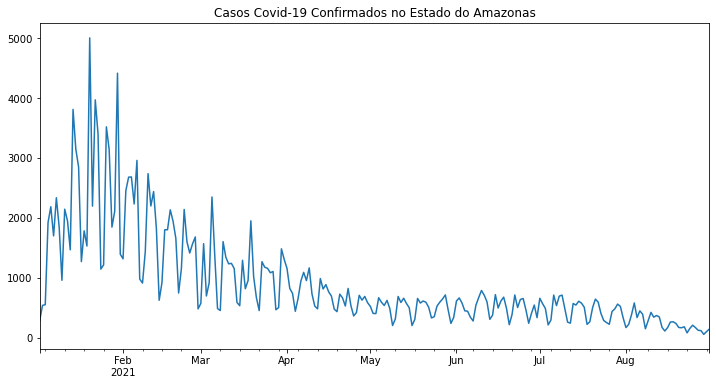

In [3]:
df['confirmed'].plot(title='Casos Covid-19 Confirmados no Estado do Amazonas');

**Gráfico de Linhas das séries de média e desvio-padrão móvel com janela de 7 dias**

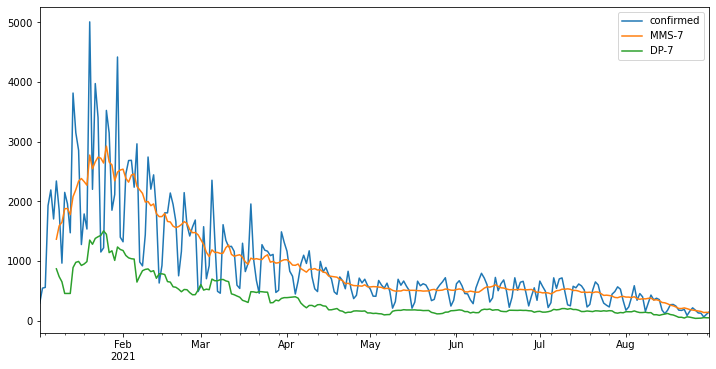

In [4]:
df['MMS-7'] = df['confirmed'].rolling(window=7).mean()
df['DP-7'] = df['confirmed'].rolling(window=7).std()

df[['confirmed','MMS-7','DP-7']].plot();

**Boxplot de Casos Confirmados por semana**

In [5]:
df['Semana'] = df.index.week % 52
df.head()

,confirmed,deaths,MMS-7,DP-7,Semana
2021-01-02,293,30,NaN,NaN,1
2021-01-03,546,20,NaN,NaN,1
2021-01-04,559,23,NaN,NaN,1
2021-01-05,1928,46,NaN,NaN,1
2021-01-06,2192,86,NaN,NaN,1


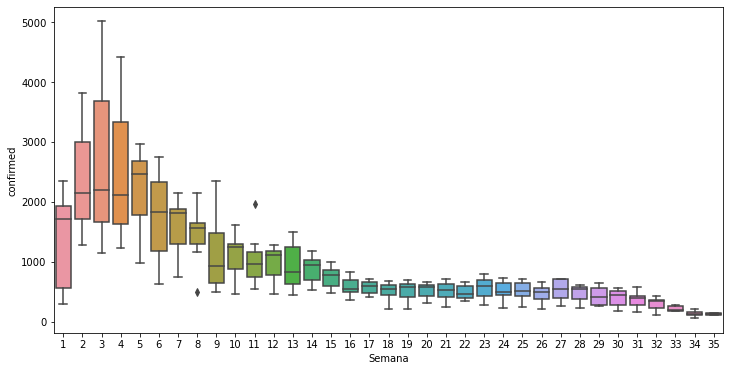

In [6]:
import seaborn as sns

sns.boxplot(x=df['Semana'], y=df['confirmed']);

**Aplicando o teste de Dickey-Fuller Aumentado para verificar se há ou não evidências contra a estacionariedade da série**

In [7]:
# fonte: https://machinelearningmastery.com/time-series-data-stationary-python/

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['confirmed'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.275691
p-value: 0.179928
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


**Resposta item 1**




Não há evidência de estacionariedade da série nos gráficos pois observa-se que há uma flutuação dos valores médios e variância quando analisamos a série como um todo.<br>

Além disso, quando aplicamos o teste de Dickey-Fuller obtemos um p-valor grande, e portanto não rejeitamos 𝐻0 e a série não é estacionária e contém uma raiz unitária.<br>

É possível inferir uma estacionariedade apenas no período entre as semanas 16 e 26 aproximadamente.<br>

## Item 2

2. Proponha uma decomposição dos dados confirmados em tendência e sazonalidade. Comente as componentes de tendência, sazonalidade e resíduos. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Esses resultados indicam a presença de autocorrelação? Justifique.


**Executando uma decomposição em tendência e sazonalidade**

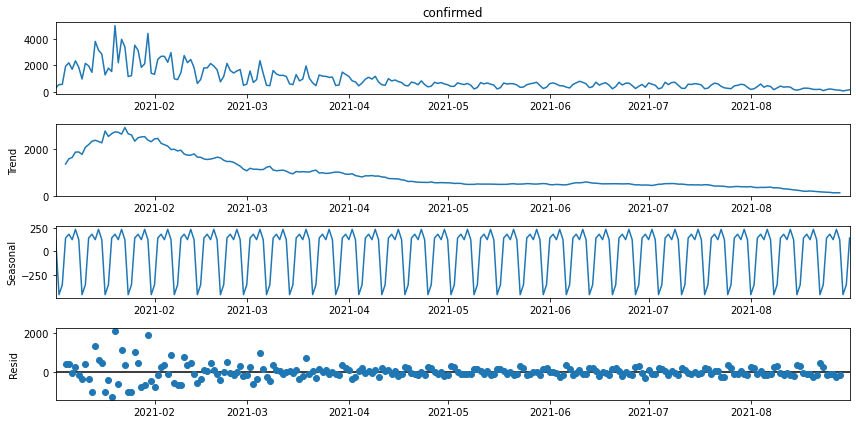

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['confirmed'], model='additive')
result.plot();

**Correlogramas - Gráficos de Autocorrelação e Autocorrelação Parcial**

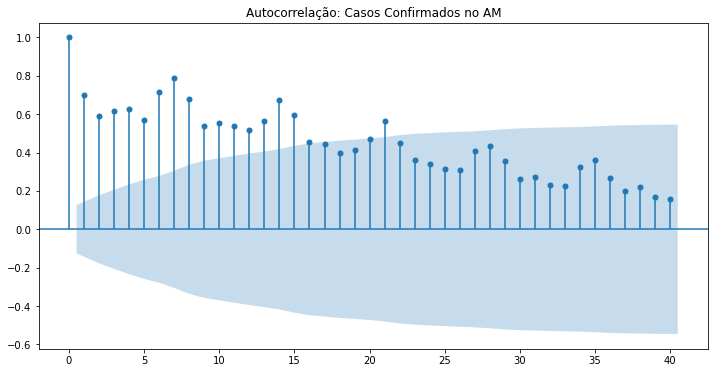

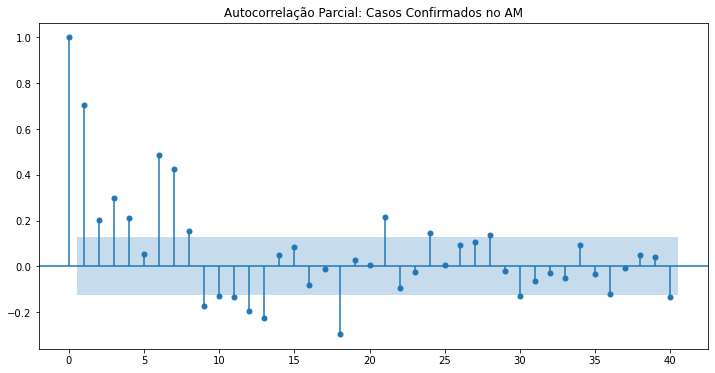

In [9]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

lags = 40
plot_acf(df['confirmed'],title='Autocorrelação: Casos Confirmados no AM',lags=lags);
plot_pacf(df['confirmed'],title='Autocorrelação Parcial: Casos Confirmados no AM',lags=lags);
plt.show();

**Resposta item 2**




Pelo gráfico de tendência observamos que a série não é estacionária.<br>

Pelo gráfico de sazonalidade percebemos que há uma sazonalidade dos dados de 7 dias.<br>

Pelo gráfico dos resíduos observa-se que a variabilidade é maior no início durante aproximadamente 2 meses, e depois a variabilidade se mantém estável exceção feita a alguns poucos pontos.<br>

No gráfico da autocorrelação observa-se o efeito da sazonalidade.<br>

Temos uma quantidade grande de pontos que ultrapassam a região em azul que representa o intervalo de confiança para a autocorrelação e autocorrelação parcial, e portanto temos um indicativo de significância da correlação observada.<br>

## Item 3

3. Divida a série de registros confirmados em treinamento e teste, com 30 observações na base de teste. A que se referem os dados de treinamento e teste e como essa divisão contribui para a análise de modelos preditivos? 

**Eliminando as colunas desnecessárias**

In [10]:
df.drop(['deaths', 'Semana', 'MMS-7', 'DP-7'], axis=1, inplace=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,confirmed
2021-01-02,293
2021-01-03,546
2021-01-04,559
2021-01-05,1928
2021-01-06,2192


**Dividindo a série em treino e teste**

In [11]:
treino = df.iloc[:-30]
teste = df.iloc[-30:]

In [12]:
print('Treino - início:', treino.index.min())
print('Treino - fim:', treino.index.max())
print('Teste - início:', teste.index.min())
print('Teste - fim:', teste.index.max())

Treino - início: 2021-01-02 00:00:00
Treino - fim: 2021-08-01 00:00:00
Teste - início: 2021-08-02 00:00:00
Teste - fim: 2021-08-31 00:00:00


**Resposta item 3**




Os dados de treinamento referem-se ao período de 2 de janeiro a 1 de agosto de 2021.<br>

Os dados de teste referem-se ao período de 2 de agosto a 31 de agosto de 2021.<br>

Essa divisão é importante para que os modelos preditivos aprendam apenas com os dados de treinamento e possam ter seu desempenho avaliado com dados que ele nunca viu antes, que são os dados de teste.<br>

Caso contrário, os modelos preditivos poderiam "decorar" os dados ao invés de aprender.<br>

## Item 4


4. Utilizando a base de treinamento de registros confirmados de COVID-19, obtenha:

    - As previsões de Holt Winters.
    
    - As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido (auto_arima), para a variável confirmed. Identifique a natureza das componentes desse melhor modelo (por exemplo, “o modelo componentes autorregressiva não sazonal, componente de médias móveis sazonal", etc).
    
    - As previsões com o método Theta usual.
          
    - As previsões com um modelo de redes neurais recorrentes (LSTM ou GRU).    
    
    

In [13]:
df_resultados = pd.DataFrame(teste['confirmed'])

**Holt Winters**

In [14]:
# Ajuste do modelo pelo Método de Holt-Winters com sazonalidade multiplicativa

from statsmodels.tsa.holtwinters import ExponentialSmoothing
hw =  ExponentialSmoothing(treino['confirmed'],trend='add',seasonal='mul',seasonal_periods=7,
                           initialization_method='heuristic')

res = hw.fit()
ypred_hw = res.forecast(30).rename('Previsão Holt-Winters')
df_resultados['Holt-Winters'] = ypred_hw

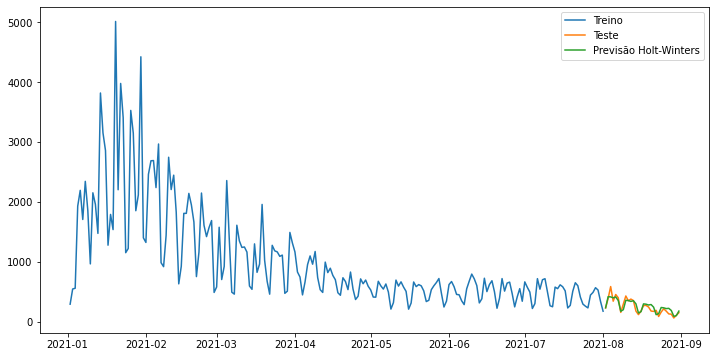

In [15]:
plt.plot(treino['confirmed'], label='Treino')
plt.plot(teste['confirmed'], label='Teste')
plt.plot(df_resultados['Holt-Winters'], label='Previsão Holt-Winters')

plt.legend()
plt.show();

**SARIMA**

In [16]:
from pmdarima import auto_arima 

stepwise_fit = auto_arima(treino['confirmed'], start_p=0, start_q=0,
                          max_p=14, max_q=7, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=3308.298, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3351.221, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3278.723, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3230.852, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3349.223, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3271.463, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3191.600, Time=0.27 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3210.220, Time=0.16 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=3193.344, Time=0.44 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3193.183, Time=0.47 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=3222.157, Time=0.27 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=3199.963, Time=0.25 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=3190.939, Time=0.62 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  212
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1588.469
Date:                                Mon, 20 Sep 2021   AIC                           3190.939
Time:                                        09:45:07   BIC                           3214.402
Sample:                                             0   HQIC                          3200.423
                                                - 212                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2248      1.579     -0.142      0.887      -3.319       2.870
ma.L1         -0.8187      0.027    -30.150      0.000      -0.872      -0.766
ar.S.L7        0.1750      0.154      1.133      0.257      -0.128       0.478
ar.S.L14       0.7548      0.147      5.117      0.000       0.466       1.044
ma.S.L7        0.1413      0.170      0.831      0.406      -0.192       0.475
ma.S.L14      -0.6853      0.143     -4.799      0.000      -0.965      -0.405
sigma2      1.904e+05   1.41e+04     13.489      0.000    1.63e+05    2.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.60   Jarque-Bera (JB):               676.13
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                             1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**O melhor modelo apresentou:**<br>
componentes de médias móveis não sazonal de ordem **q=1** e sazonal de ordem **Q=2 ou 1**,<br>
componente integrado não sazonal de ordem **d=1**, <br>
componente autorregressivo sazonal de ordem **P=2** e <br>
componente sazonal de ordem **m=7**.

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelo = SARIMAX(treino['confirmed'],trend='c', order=(0,1,1),seasonal_order=(2,0,2,7))
res = modelo.fit()
print(res.summary())

# Obtain predicted values
inicio=len(treino)
fim=len(treino)+len(teste)-1
ypred_sarima = res.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsões SARIMA')
ypred_sarima.index = teste.index
df_resultados['Sarima'] = ypred_sarima

                                       SARIMAX Results                                        
Dep. Variable:                              confirmed   No. Observations:                  212
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1588.469
Date:                                Mon, 20 Sep 2021   AIC                           3190.939
Time:                                        09:45:08   BIC                           3214.402
Sample:                                    01-02-2021   HQIC                          3200.423
                                         - 08-01-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2248      1.579     -0.142      0.887      -3.319       2.870
ma.

C:\Users\joaop\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


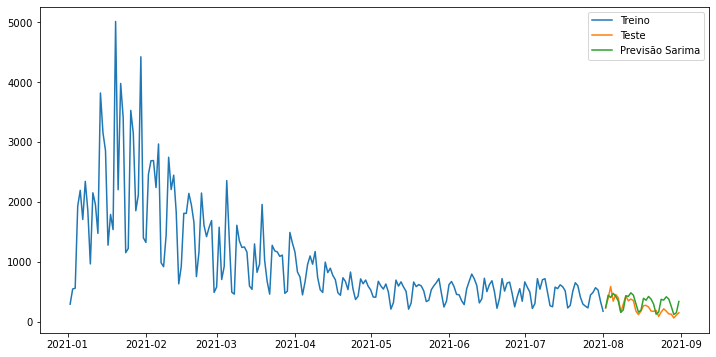

In [18]:
plt.plot(treino['confirmed'], label='Treino')
plt.plot(teste['confirmed'], label='Teste')
plt.plot(df_resultados['Sarima'], label='Previsão Sarima')

plt.legend()
plt.show();

**Theta**

In [19]:
from statsmodels.tsa.forecasting.theta import ThetaModel
tm = ThetaModel(treino['confirmed'],deseasonalize=True,period=7)
res = tm.fit()
print(res.summary())
ypred_tm = res.forecast(30)
df_resultados['Theta'] = ypred_tm

                              ThetaModel Results                              
Dep. Variable:              confirmed   No. Observations:                  212
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Mon, 20 Sep 2021   Deseas. Method:         Multiplicative
Time:                        09:45:08   Period:                              7
Sample:                    01-02-2021                                         
                         - 08-01-2021                                         
   Parameter Estimates   
           Parameters    
-------------------------
b0     -9.319733648465622
alpha 0.29338840725280385
-------------------------


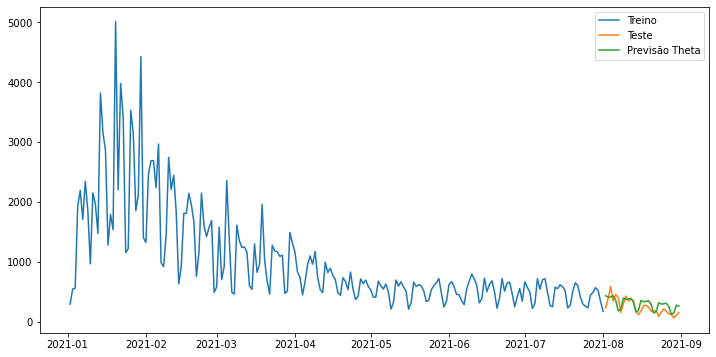

In [20]:
plt.plot(treino['confirmed'], label='Treino')
plt.plot(teste['confirmed'], label='Teste')
plt.plot(df_resultados['Theta'], label='Previsão Theta')

plt.legend()
plt.show();

**Rede Neural Recorrente LSTM**

In [21]:
# Padronizando os dados da modelagem
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(treino)
scaled_treino = scaler.transform(treino)
scaled_teste = scaler.transform(teste)
print(scaled_treino.min(),scaled_treino.max())
print(scaled_teste.min(),scaled_teste.max())

0.0 0.9999999999999999
-0.023380922822263603 0.08504034761018


In [22]:
# Carregando as bibliotecas para redes dinâmicas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Definindo o gerador de séries temporais e valores para os parâmetros length e batch_size
# Vamos redefinir o tamanho do lote para o procedimento iterativo
# infos tamanho do lote http://deeplearningbook.com.br/o-efeito-do-batch-size-no-treinamento-de-redes-neurais-artificiais/
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_treino, scaled_treino, length=n_input, batch_size=n_features)

# Definindo o modelo - camada LSTM e uma camada Dense
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Ajuste do modelo
model.fit(generator,epochs=200)

Epoch 1/200
205/205 [==============================] - 1s 2ms/step - loss: 0.0749
Epoch 2/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0685
Epoch 3/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0726
Epoch 4/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0744
Epoch 5/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0712
Epoch 6/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0671
Epoch 7/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0698
Epoch 8/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0656
Epoch 9/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0672
Epoch 10/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0606
Epoch 11/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0647
Epoch 12/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0594
Epoch 13/200


205/205 [==============================] - 0s 2ms/step - loss: 0.0428
Epoch 100/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0423
Epoch 101/200
205/205 [==============================] - 1s 6ms/step - loss: 0.0416
Epoch 102/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0426
Epoch 103/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0412
Epoch 104/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0409
Epoch 105/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0410
Epoch 106/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0410
Epoch 107/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0416
Epoch 108/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0405
Epoch 109/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0417
Epoch 110/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0416
Epoch 

205/205 [==============================] - 1s 3ms/step - loss: 0.0330
Epoch 197/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0338
Epoch 198/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0322
Epoch 199/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 200/200
205/205 [==============================] - 0s 2ms/step - loss: 0.0326


In [24]:
# Fazendo as previsões para as próximas observações
test_predictions = []

first_eval_batch = scaled_treino[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(teste)):
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
# Retornando a padronização
ypred_lstm = scaler.inverse_transform(test_predictions)
df_resultados['LSTM'] = ypred_lstm

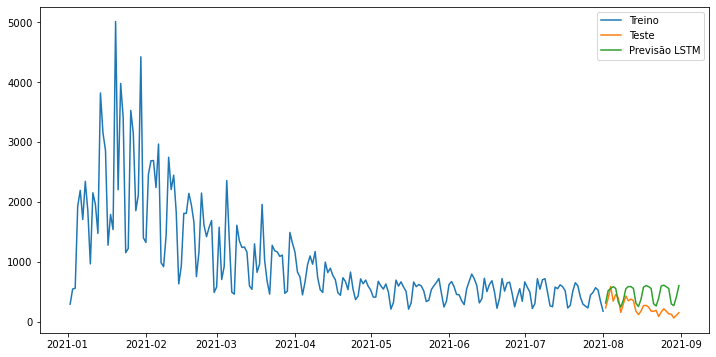

In [25]:
plt.plot(treino['confirmed'], label='Treino')
plt.plot(teste['confirmed'], label='Teste')
plt.plot(df_resultados['LSTM'], label='Previsão LSTM')

plt.legend()
plt.show();

**Resposta Item 4**


**Resumo das Predições**

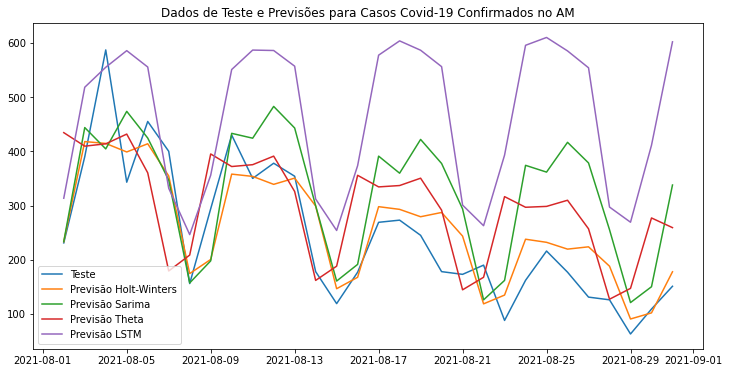

In [26]:
# plt.plot(treino['confirmed'], label='Treino')
plt.plot(teste['confirmed'], label='Teste')
plt.plot(df_resultados['Holt-Winters'], label='Previsão Holt-Winters')
plt.plot(df_resultados['Sarima'], label='Previsão Sarima')
plt.plot(df_resultados['Theta'], label='Previsão Theta')
plt.plot(df_resultados['LSTM'], label='Previsão LSTM')


plt.title('Dados de Teste e Previsões para Casos Covid-19 Confirmados no AM')
plt.legend()
plt.show()

## Item 5


5. Utilize o erro absoluto médio para comparar as previsões obtidas com as observações da base de teste. Qual o método que produz as melhores previsões? Represente em um mesmo gráfico a base de treinamento, de teste e as previsões obtidas pelos quatro métodos.


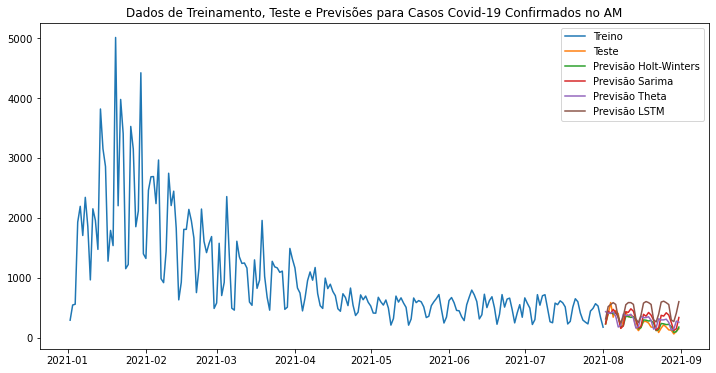

In [27]:
plt.plot(treino['confirmed'], label='Treino')
plt.plot(teste['confirmed'], label='Teste')
plt.plot(df_resultados['Holt-Winters'], label='Previsão Holt-Winters')
plt.plot(df_resultados['Sarima'], label='Previsão Sarima')
plt.plot(df_resultados['Theta'], label='Previsão Theta')
plt.plot(df_resultados['LSTM'], label='Previsão LSTM')


plt.title('Dados de Treinamento, Teste e Previsões para Casos Covid-19 Confirmados no AM')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_absolute_error
MAE_hw = mean_absolute_error(df_resultados['confirmed'], ypred_hw)
MAE_sarima = mean_absolute_error(df_resultados['confirmed'], ypred_sarima)
MAE_tm = mean_absolute_error(df_resultados['confirmed'], ypred_tm)
MAE_lstm = mean_absolute_error(df_resultados['confirmed'], ypred_lstm)

In [29]:
print('MAE Holt-Winters:', MAE_hw)
print('MAE Sarima:', MAE_sarima)
print('MAE Theta:', MAE_tm)
print('MAE LSTM:', MAE_lstm)

MAE Holt-Winters: 48.828284390345736
MAE Sarima: 103.4251937756761
MAE Theta: 93.574545239474
MAE LSTM: 223.11427353024482


**Análise dos Resíduos do melhor modelo**

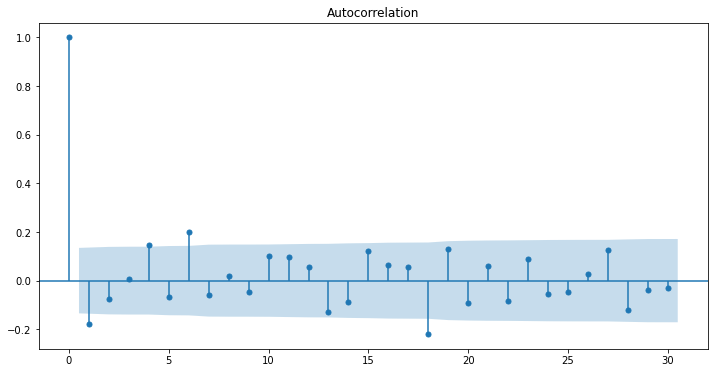

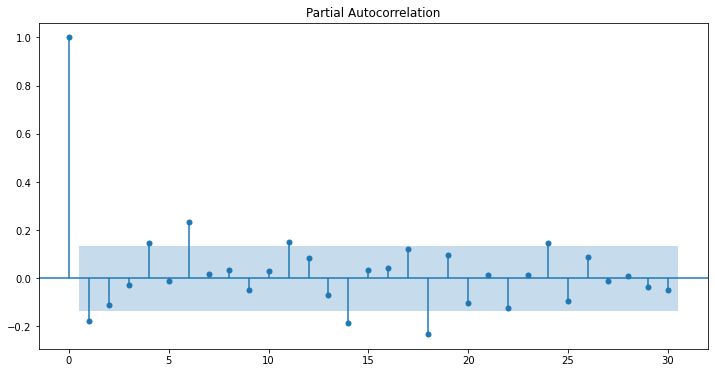

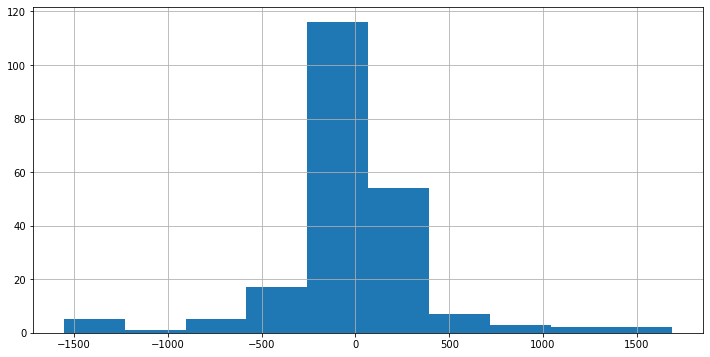

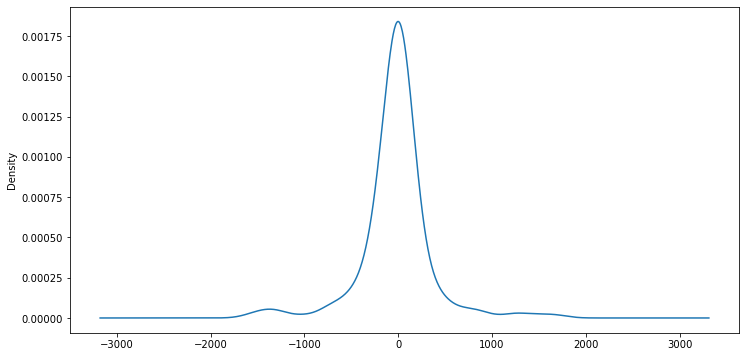

In [30]:
# Método de Holt-Winters

hw =  ExponentialSmoothing(treino['confirmed'],trend='add',seasonal='mul',seasonal_periods=7,
                           initialization_method='heuristic')

res = hw.fit()

# Correlograma dos resíduos
resíduos_hw = res.resid
plot_acf(resíduos_hw, lags=30)
plot_pacf(resíduos_hw, lags=30)
plt.show()

# Histograma e densidade alisada dos resíduos
resíduos_hw.hist()
plt.show()
resíduos_hw.plot(kind='kde')
plt.show()

**Resposta Item 5**


Utilizando-se a métrica MAE, os modelos com as melhores previsões na ordem decrescente são:<br>

1o.) Holt-Winters <br>

2o.) Theta <br>

3o.) Sarima <br>

4o.) LSTM <br>

Além da métrica MAE com menor erro, é importante a análise dos resíduos.<br>
Nesse caso a distribuição dos resíduos demonstra-se aproximadamente aleatória e o correlograma apenas pequena correlação.